1-模型定义

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, 3), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, 3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d((2, 2))
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*30*30, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(1024, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64*30*30)
        x = self.classifier(x)
        return x

In [3]:
model = MyModel()

In [4]:
model.to('mps')

MyModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=57600, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

2-训练数据初始化

In [5]:
transform = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])

In [6]:
train_dataset = torchvision.datasets.ImageFolder('/Users/cuizheng/Projects/notebook/archive/training_set/training_set', transform)

In [7]:
test_dataset = torchvision.datasets.ImageFolder('/Users/cuizheng/Projects/notebook/archive/test_set/test_set', transform)

In [37]:
train_dataset.classes, test_dataset.classes

(['cats', 'dogs'], ['cats', 'dogs'])

In [9]:
len(train_dataset),len(test_dataset)

(8005, 2029)

In [10]:
train_dataset.class_to_idx

{'cats': 0, 'dogs': 1}

In [38]:
id_to_class = dict((v, k) for k, v in train_dataset.class_to_idx.items())

In [39]:
id_to_class

{0: 'cats', 1: 'dogs'}

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [14]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [15]:
images, labels = next(iter(train_dataloader))

In [16]:
images.shape

torch.Size([32, 3, 256, 256])

In [17]:
import matplotlib.pyplot as plt

In [18]:
im = images[0].permute(1, 2, 0)
im.shape

torch.Size([256, 256, 3])

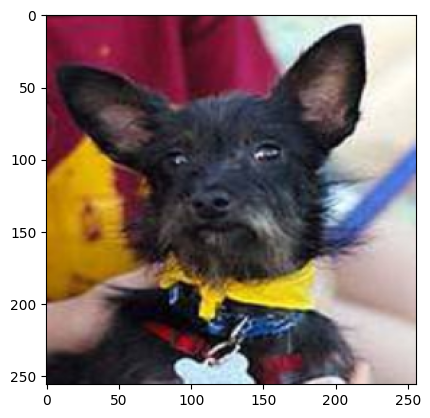

In [19]:
im.numpy()
plt.imshow(im)

In [20]:
plt.figure(figsize=(9,6))

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

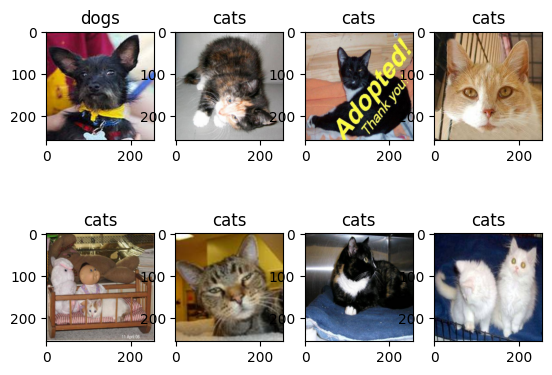

In [21]:
for i, (img, label) in enumerate(zip(images[:8], labels[:8])):
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(2,4, i+1)
    plt.title(id_to_class.get(label.item()))
    plt.imshow(img)

使用模型预测一下

In [22]:
images = images.to('mps')
pred = model(images)
pred.shape

torch.Size([32, 2])

批量训练的思路方法

In [23]:
loss_fn = nn.CrossEntropyLoss()

In [24]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    model.train()
    for x, y in trainloader:
        x, y = x.to('mps'), y.to('mps')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to('mps'), y.to('mps')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [26]:
epochs = 20

In [27]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dataloader,
                                                                 test_dataloader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.634 accuracy: 0.637 test_loss：  0.592 test_accuracy: 0.689
epoch:  1 loss：  0.527 accuracy: 0.736 test_loss：  0.49 test_accuracy: 0.757
epoch:  2 loss：  0.439 accuracy: 0.793 test_loss：  0.58 test_accuracy: 0.748
epoch:  3 loss：  0.373 accuracy: 0.832 test_loss：  0.487 test_accuracy: 0.769
epoch:  4 loss：  0.282 accuracy: 0.881 test_loss：  0.512 test_accuracy: 0.768
epoch:  5 loss：  0.214 accuracy: 0.912 test_loss：  0.632 test_accuracy: 0.751
epoch:  6 loss：  0.164 accuracy: 0.937 test_loss：  0.659 test_accuracy: 0.767
epoch:  7 loss：  0.122 accuracy: 0.955 test_loss：  0.705 test_accuracy: 0.768
epoch:  8 loss：  0.105 accuracy: 0.961 test_loss：  0.789 test_accuracy: 0.774
epoch:  9 loss：  0.116 accuracy: 0.957 test_loss：  0.908 test_accuracy: 0.758
epoch:  10 loss：  0.081 accuracy: 0.968 test_loss：  0.835 test_accuracy: 0.766
epoch:  11 loss：  0.068 accuracy: 0.974 test_loss：  0.942 test_accuracy: 0.77
epoch:  12 loss：  0.069 accuracy: 0.978 test_loss：  1.008 test_ac

In [28]:
torch.save(model.state_dict(), 'model.pth')

In [29]:
model_new = MyModel()
model_new.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [30]:
model_new.eval()
model_new.to('mps')

MyModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=57600, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [34]:
from PIL import Image
def is_a_dog(path, model):
    # input
    image = Image.open(path)
    image = image.convert('RGB')
    img = transform(image)
    img = img.unsqueeze(0)
    img = img.to('mps')
    # call model
    output = model(img)
    c = torch.argmax(output, 1)
    label = id_to_class.get(c.item())
    return img, label

In [35]:
img, label = is_a_dog('./pics/mypic.jpg', model_new)

Text(0.5, 1.0, 'dogs')

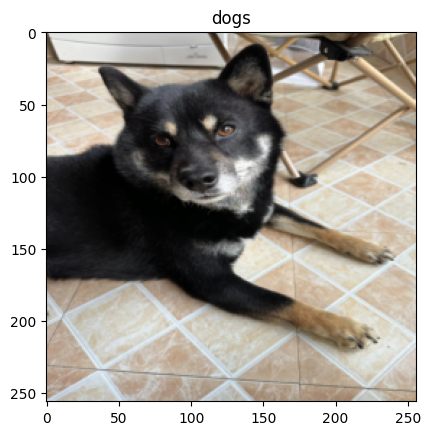

In [36]:
img = img.squeeze()
img =img.permute(1,2,0)
img = img.cpu().numpy()
plt.imshow(img)
plt.title(label)